In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

2023-11-07 09:25:17.497645: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Use a raw string (r) to define the file path
file_path = r'Yale_229_4039030_Histogram_Hourly.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Convert it to a pandas datetime object if it's not already
df['UTC start time'] = pd.to_datetime(df['UTC start time'])

# Set the 'UTC start time' column as the DataFrame index
df.set_index('UTC start time', inplace=True)

In [3]:
# Get basic information about the DataFrame
print(df.info())

# Get summary statistics of numeric columns
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37875 entries, 2016-05-12 15:00:00 to 2020-09-06 16:00:00
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Patient ID              37875 non-null  int64  
 1   Device ID               37875 non-null  int64  
 2   Region start time       37875 non-null  object 
 3   Time zone               37875 non-null  object 
 4   Pattern A Channel 1     37863 non-null  float64
 5   Pattern A Channel 2     37863 non-null  float64
 6   Pattern B Channel 1     37863 non-null  float64
 7   Pattern B Channel 2     37863 non-null  float64
 8   Episode starts          37863 non-null  float64
 9   Episode starts with RX  37863 non-null  float64
 10  Long episodes           37863 non-null  float64
 11  Magnet swipes           16513 non-null  float64
 12  Saturations             16513 non-null  float64
 13  Hist hours              37875 non-null  int64  
 14  Mag

In [4]:
print(df.columns)

Index(['Patient ID', 'Device ID', 'Region start time', 'Time zone',
       'Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1',
       'Pattern B Channel 2', 'Episode starts', 'Episode starts with RX',
       'Long episodes', 'Magnet swipes', 'Saturations', 'Hist hours',
       'Mag sat hours'],
      dtype='object')


In [5]:
# Calculate the total hours when there is data for patterns
total_hours_with_data = (df['Hist hours'] == 1).sum()

# Convert total hours to years
years_with_data = total_hours_with_data / (365 * 24)  # Assuming 365 days per year and 24 hours per day

print(f"Total hours with data for patterns: {total_hours_with_data} hours")
print(f"Equivalent number of years with data for patterns: {years_with_data:.2f} years")

Total hours with data for patterns: 37875 hours
Equivalent number of years with data for patterns: 4.32 years


In [6]:
# Check for missing values (NaN) in 'Hist hours'
missing_values = df['Hist hours'].isnull().sum()

# Check for values equal to 0 in 'Hist hours'
zero_values = (df['Hist hours'] == 0).sum()

print(f"Number of missing values (NaN) in 'Hist hours': {missing_values}")
print(f"Number of values equal to 0 in 'Hist hours': {zero_values}")

Number of missing values (NaN) in 'Hist hours': 0
Number of values equal to 0 in 'Hist hours': 0


In [6]:
# Check distribution and statistics of the target variable
print(df['Long episodes'].describe())

# Check for negative values in the target variable
negative_values = (df['Long episodes'] < 0).sum()
print(f"Number of negative values in 'Long episodes': {negative_values}")

count    37863.000000
mean         2.008452
std          5.493604
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         59.000000
Name: Long episodes, dtype: float64
Number of negative values in 'Long episodes': 0


In [8]:
# Calculate the average number of actual long episodes
average_actual_long_episodes = np.mean(df['Long episodes'])
print(f'Average Actual Long Episodes: {average_actual_long_episodes}')

Average Actual Long Episodes: 2.0084515225946173


In [9]:
# Resample the data into 24-hour intervals and calculate the average of 'Long episodes'
average_per_24_hours = df['Long episodes'].resample('24H').mean()

# Calculate the maximum and minimum average long episodes in a day
max_average = average_per_24_hours.max()
min_average = average_per_24_hours.min()

# Calculate the sum of all daily averages
sum_of_averages = average_per_24_hours.sum()

# Calculate the number of days
num_days = len(average_per_24_hours)

# Calculate the average per all days (excluding max and min)
average_per_all_days = (sum_of_averages - max_average - min_average) / (num_days - 2)

# Print the results
print("Average per 24 Hours:")
print(average_per_24_hours)
print(f"Maximum Average Long Episodes in a Day: {max_average}")
print(f"Minimum Average Long Episodes in a Day: {min_average}")
print(f"Average Long Episodes per All Days (Excluding Max and Min): {average_per_all_days}")


Average per 24 Hours:
UTC start time
2016-05-12    0.555556
2016-05-13    0.083333
2016-05-14    0.166667
2016-05-15    1.333333
2016-05-16    0.958333
                ...   
2020-09-02    0.000000
2020-09-03    0.000000
2020-09-04    0.000000
2020-09-05    0.041667
2020-09-06    0.000000
Freq: 24H, Name: Long episodes, Length: 1579, dtype: float64
Maximum Average Long Episodes in a Day: 24.5
Minimum Average Long Episodes in a Day: 0.0
Average Long Episodes per All Days (Excluding Max and Min): 1.993931867822166


# Try 4 logarithmic transformation + 'long episode'


Epoch 1/5
371/371 [==============================] - 18s 42ms/step - loss: 0.1607
Epoch 2/5
371/371 [==============================] - 15s 41ms/step - loss: 0.1518
Epoch 3/5
371/371 [==============================] - 15s 42ms/step - loss: 0.1465
Epoch 4/5
371/371 [==============================] - 15s 42ms/step - loss: 0.1391
Epoch 5/5
93/93 [==============================] - 2s 15ms/step
Mean Absolute Error: 0.48715151734336354


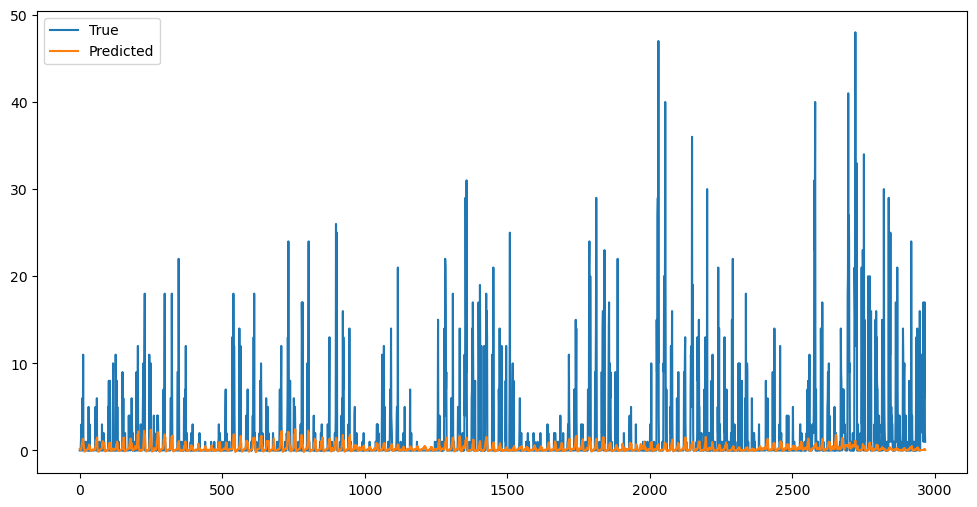

1/1 [==============================] - 0s 27ms/step
Forecasted Seizures in the Next 24 Hours: 0


In [4]:
# logarithmic transformation + 'long episode' as a feature (one layer of LSTM)
# Transform the target variable using a logarithmic transformation
df['Log Long episodes'] = np.log1p(df['Long episodes'])

# Select relevant features (excluding 'Long episodes') and target variable
selected_features = ['Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2',
                     'Episode starts']
target_variable = 'Log Long episodes'  # Use the transformed target variable

# Preprocess data
df[selected_features] = df[selected_features].fillna(0)  # Fill missing values (you can use other strategies)
scaler = StandardScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])

# Define time window size (7 days)
sequence_length = 24 * 7  # Assuming hourly data

# Create sequences for training and testing using a smaller dataset
X, y = [], []                          # Initialize empty lists for storing input sequences (X) and target values (y)
sample_size = 15000                     # Use a smaller sample size for demonstration purposes
for i in range(sample_size - sequence_length):
    # Extract a sequence of length 'sequence_length' from the standardized features
    X.append(df[selected_features].values[i:i + sequence_length])
    # Extract the log-transformed target variable ('Log Long episodes') for the corresponding time period
    y.append(df[target_variable].values[i + sequence_length])

X, y = np.array(X), np.array(y)         # Convert Python lists to NumPy arrays for model compatibility

# Calculate the number of data points for training and testing
total_samples = len(X)                 # Total number of samples in the dataset
train_size = int(0.8 * total_samples)  # Define the size of the training set as 80% of the data
test_size = total_samples - train_size # Define the size of the testing set as the remaining 20%

# Split the data into training and testing sets based on the calculated sizes
X_train, y_train = X[:train_size], y[:train_size]        # Training data
X_test, y_test = X[train_size:], y[train_size:]          # Testing data

# Define and configure the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(sequence_length, len(selected_features))))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with fewer epochs
epochs = 5  # Adjust as needed
model.fit(X_train, y_train, epochs=epochs, batch_size=32)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Visualize predictions (example)
plt.figure(figsize=(12, 6))
plt.plot(np.expm1(y_test), label='True')  # Reverse the logarithmic transformation for visualization
plt.plot(np.expm1(y_pred), label='Predicted')  # Reverse the logarithmic transformation for visualization
plt.legend()
plt.show()

# In the forecasting function, you'll need to reverse the logarithmic transformation
def forecast_seizures(data_point):
    # Predict the log-transformed number of seizures for the data point
    log_prediction = model.predict(data_point.reshape(1, sequence_length, len(selected_features)))[0][0]
    # Reverse the logarithmic transformation
    prediction = np.expm1(log_prediction)
    return round(prediction)

# Choose a data point from the test set (you can replace this with any data point)
data_point_index = 0
data_point = X_test[data_point_index]

# Forecast seizures for the chosen data point
forecasted_seizures = forecast_seizures(data_point)
print(f'Forecasted Seizures in the Next 24 Hours: {forecasted_seizures}')


Epoch 1/50
371/371 [==============================] - 56s 138ms/step - loss: 0.1670
Epoch 2/50
371/371 [==============================] - 51s 138ms/step - loss: 0.1579
Epoch 3/50
371/371 [==============================] - 51s 137ms/step - loss: 0.1522
Epoch 4/50
371/371 [==============================] - 51s 137ms/step - loss: 0.1485
Epoch 5/50
371/371 [==============================] - 51s 137ms/step - loss: 0.1407
Epoch 6/50
371/371 [==============================] - 51s 137ms/step - loss: 0.1378
Epoch 7/50
371/371 [==============================] - 51s 138ms/step - loss: 0.1464
Epoch 8/50
371/371 [==============================] - 51s 137ms/step - loss: 0.1355
Epoch 9/50
371/371 [==============================] - 51s 137ms/step - loss: 0.1328
Epoch 10/50
371/371 [==============================] - 51s 137ms/step - loss: 0.1334
Epoch 11/50
371/371 [==============================] - 51s 137ms/step - loss: 0.1328
Epoch 12/50
371/371 [==============================] - 51s 137ms/step - lo

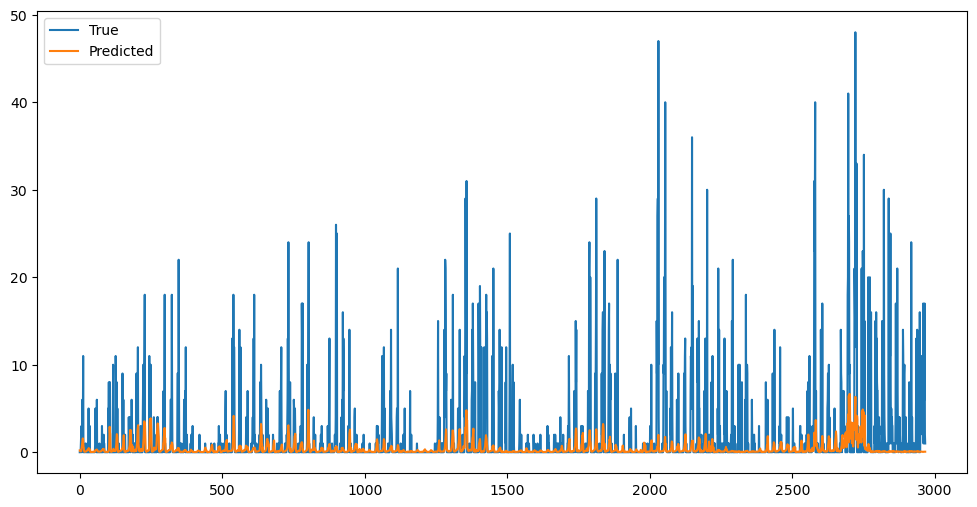

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Assuming you have already loaded and preprocessed your dataset as 'df'

# Logarithmic transformation + 'Long episodes' as a feature
df['Log Long episodes'] = np.log1p(df['Long episodes'])

# Select relevant features (excluding 'Long episodes') and target variable
selected_features = ['Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2',
                     'Episode starts']
target_variable = 'Log Long episodes'  # Use the transformed target variable

# Preprocess data
df[selected_features] = df[selected_features].fillna(0)  # Fill missing values (you can use other strategies)
scaler = StandardScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])

# Define time window size (7 days)
sequence_length = 24 * 7  # Assuming hourly data

# Create sequences for training and testing using a smaller dataset
X, y = [], []
sample_size = 15000  # Use a smaller sample size for demonstration purposes
for i in range(sample_size - sequence_length):
    X.append(df[selected_features].values[i:i + sequence_length])
    y.append(df[target_variable].values[i + sequence_length])

X, y = np.array(X), np.array(y)

# Calculate the number of data points for training and testing
total_samples = len(X)
train_size = int(0.8 * total_samples)
test_size = total_samples - train_size

# Split the data into training and testing sets based on the calculated sizes
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Define and configure the LSTM model with dropout
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(sequence_length, len(selected_features))))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with more epochs
epochs = 50  # Increased number of epochs
batch_size = 32
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Forecast seizures for the chosen data point
def forecast_seizures(data_point):
    log_prediction = model.predict(data_point.reshape(1, sequence_length, len(selected_features)))[0][0]
    prediction = np.expm1(log_prediction)
    return round(prediction)

# Choose a data point from the test set (you can replace this with any data point)
data_point_index = 0
data_point = X_test[data_point_index]

# Forecast seizures for the chosen data point
forecasted_seizures = forecast_seizures(data_point)
print(f'Forecasted Seizures in the Next 24 Hours: {forecasted_seizures}')

# Visualize predictions (example)
plt.figure(figsize=(12, 6))
plt.plot(np.expm1(y_test), label='True')
plt.plot(np.expm1(y_pred), label='Predicted')
plt.legend()
plt.show()

Epoch 1/5
371/371 [==============================] - 15s 35ms/step - loss: 0.1650
Epoch 2/5
371/371 [==============================] - 13s 35ms/step - loss: 0.1435
Epoch 3/5
371/371 [==============================] - 14s 37ms/step - loss: 0.1408
Epoch 4/5
371/371 [==============================] - 14s 37ms/step - loss: 0.1425
Epoch 5/5
93/93 [==============================] - 2s 13ms/step
Mean Absolute Error: 0.5036341019996579


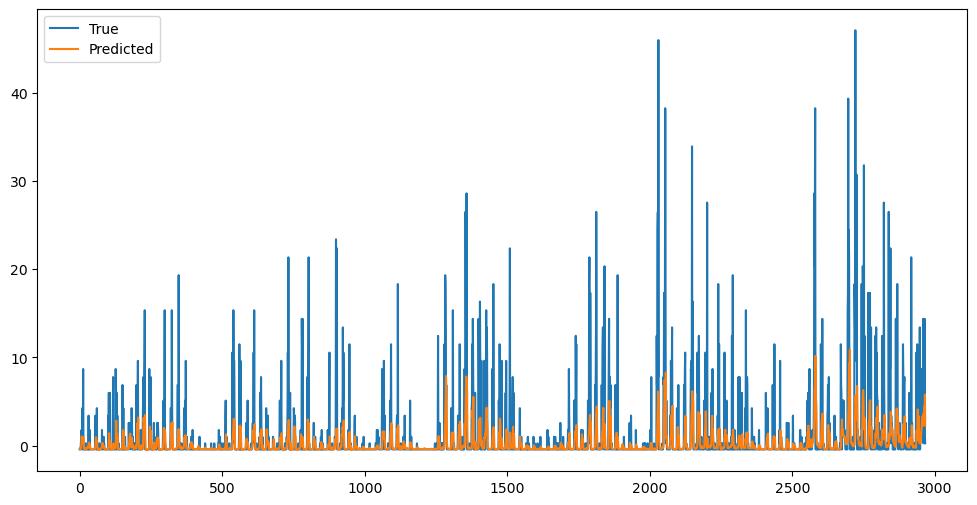

1/1 [==============================] - 0s 24ms/step
Forecasted Seizures in the Next 24 Hours: 0


In [4]:
# logarithmic transformation + 'long episode' as a feature (one layer of LSTM)
# Transform the target variable using a logarithmic transformation
df['Log Long episodes'] = np.log1p(df['Long episodes'])

# Select relevant features (excluding 'Long episodes') and target variable
selected_features = ['Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2',
                     'Episode starts','Log Long episodes']
target_variable = 'Log Long episodes'  # Use the transformed target variable

# Preprocess data
df[selected_features] = df[selected_features].fillna(0)  # Fill missing values (you can use other strategies)
scaler = StandardScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])

# Define time window size (7 days)
sequence_length = 24 * 7  # Assuming hourly data

# Create sequences for training and testing using a smaller dataset
X, y = [], []                          # Initialize empty lists for storing input sequences (X) and target values (y)
sample_size = 15000                     # Use a smaller sample size for demonstration purposes
for i in range(sample_size - sequence_length):
    # Extract a sequence of length 'sequence_length' from the standardized features
    X.append(df[selected_features].values[i:i + sequence_length])
    # Extract the log-transformed target variable ('Log Long episodes') for the corresponding time period
    y.append(df[target_variable].values[i + sequence_length])

X, y = np.array(X), np.array(y)         # Convert Python lists to NumPy arrays for model compatibility

# Calculate the number of data points for training and testing
total_samples = len(X)                 # Total number of samples in the dataset
train_size = int(0.8 * total_samples)  # Define the size of the training set as 80% of the data
test_size = total_samples - train_size # Define the size of the testing set as the remaining 20%

# Split the data into training and testing sets based on the calculated sizes
X_train, y_train = X[:train_size], y[:train_size]        # Training data
X_test, y_test = X[train_size:], y[train_size:]          # Testing data

# Define and configure the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(sequence_length, len(selected_features))))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with fewer epochs
epochs = 5  # Adjust as needed
model.fit(X_train, y_train, epochs=epochs, batch_size=32)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Visualize predictions (example)
plt.figure(figsize=(12, 6))
plt.plot(np.expm1(y_test), label='True')  # Reverse the logarithmic transformation for visualization
plt.plot(np.expm1(y_pred), label='Predicted')  # Reverse the logarithmic transformation for visualization
plt.legend()
plt.show()

# In the forecasting function, you'll need to reverse the logarithmic transformation
def forecast_seizures(data_point):
    # Predict the log-transformed number of seizures for the data point
    log_prediction = model.predict(data_point.reshape(1, sequence_length, len(selected_features)))[0][0]
    # Reverse the logarithmic transformation
    prediction = np.expm1(log_prediction)
    return round(prediction)

# Choose a data point from the test set (you can replace this with any data point)
data_point_index = 0
data_point = X_test[data_point_index]

# Forecast seizures for the chosen data point
forecasted_seizures = forecast_seizures(data_point)
print(f'Forecasted Seizures in the Next 24 Hours: {forecasted_seizures}')


'Long episodes' (target variable) shoudl not be added to the features when building a predictive model. Including the target variable as a feature would lead to data leakage, as the model would effectively have access to the future information it's trying to predict, which would result in unrealistic and overly optimistic model performance.

The 'Long episodes' should be used as the target variable for your predictive model, and we could use other features (like 'Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2', and 'Episode starts') as input features to predict 'Long episodes' in the future.

In the code, I used the logarithmically transformed 'Log Long episodes' as the target variable for the LSTM model. This transformation helps improve the stability of the predictions, especially if 'Long episodes' have a wide range of values or include zeros.

## Adding additional layers 

Epoch 1/5
371/371 [==============================] - 29s 68ms/step - loss: 0.1666
Epoch 2/5
371/371 [==============================] - 25s 68ms/step - loss: 0.1485
Epoch 3/5
371/371 [==============================] - 26s 71ms/step - loss: 0.1451
Epoch 4/5
371/371 [==============================] - 26s 71ms/step - loss: 0.1429
Epoch 5/5
93/93 [==============================] - 3s 25ms/step
Mean Absolute Error: 0.5256002604164723


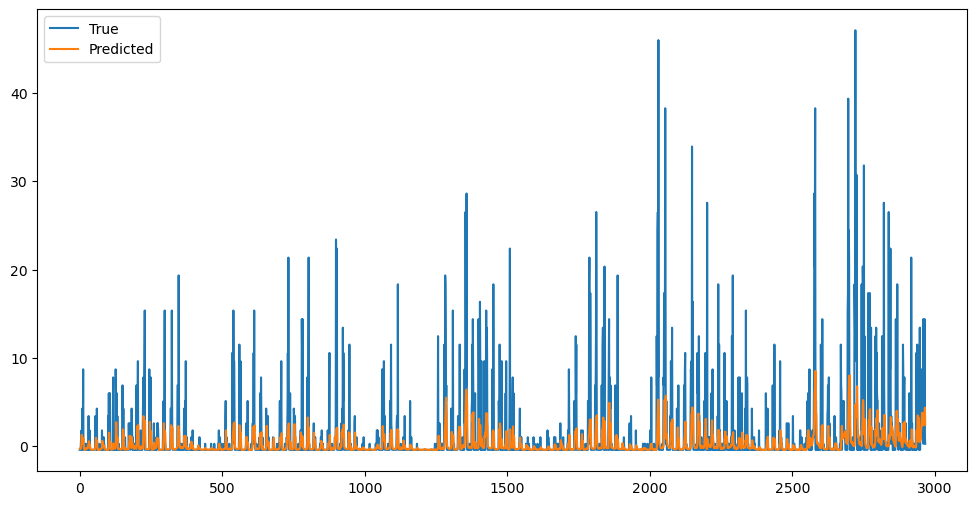

1/1 [==============================] - 0s 34ms/step
Forecasted Seizures in the Next 24 Hours: 0


In [5]:
# Adding additional layer - Second LSTM layer
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Logarithmic transformation + 'long episode' as a feature
df['Log Long episodes'] = np.log1p(df['Long episodes'])

# Select relevant features (excluding 'Long episodes') and target variable
selected_features = ['Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2',
                     'Episode starts', 'Log Long episodes']
target_variable = 'Log Long episodes'  # Use the transformed target variable

# Preprocess data
df[selected_features] = df[selected_features].fillna(0)  # Fill missing values (you can use other strategies)
scaler = StandardScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])

# Define time window size (7 days)
sequence_length = 24 * 7  # Assuming hourly data

# Create sequences for training and testing using a smaller dataset
X, y = [], []                          # Initialize empty lists for storing input sequences (X) and target values (y)
sample_size = 15000                     # Use a smaller sample size for demonstration purposes
for i in range(sample_size - sequence_length):
    # Extract a sequence of length 'sequence_length' from the standardized features
    X.append(df[selected_features].values[i:i + sequence_length])
    # Extract the log-transformed target variable ('Log Long episodes') for the corresponding time period
    y.append(df[target_variable].values[i + sequence_length])

X, y = np.array(X), np.array(y)         # Convert Python lists to NumPy arrays for model compatibility

# Calculate the number of data points for training and testing
total_samples = len(X)                 # Total number of samples in the dataset
train_size = int(0.8 * total_samples)  # Define the size of the training set as 80% of the data
test_size = total_samples - train_size # Define the size of the testing set as the remaining 20%

# Split the data into training and testing sets based on the calculated sizes
X_train, y_train = X[:train_size], y[:train_size]        # Training data
X_test, y_test = X[train_size:], y[train_size:]          # Testing data

# Define and configure the LSTM model with two LSTM layers
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, len(selected_features)))) # Add return_sequences=True
model.add(LSTM(units=50))  # Second LSTM layer
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with fewer epochs
epochs = 5  # Adjust as needed
model.fit(X_train, y_train, epochs=epochs, batch_size=32)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Visualize predictions (example)
plt.figure(figsize=(12, 6))
plt.plot(np.expm1(y_test), label='True')  # Reverse the logarithmic transformation for visualization
plt.plot(np.expm1(y_pred), label='Predicted')  # Reverse the logarithmic transformation for visualization
plt.legend()
plt.show()

# In the forecasting function, you'll need to reverse the logarithmic transformation
def forecast_seizures(data_point):
    # Predict the log-transformed number of seizures for the data point
    log_prediction = model.predict(data_point.reshape(1, sequence_length, len(selected_features)))[0][0]
    # Reverse the logarithmic transformation
    prediction = np.expm1(log_prediction)
    return round(prediction)

# Choose a data point from the test set (you can replace this with any data point)
data_point_index = 0
data_point = X_test[data_point_index]

# Forecast seizures for the chosen data point
forecasted_seizures = forecast_seizures(data_point)
print(f'Forecasted Seizures in the Next 24 Hours: {forecasted_seizures}')

Epoch 1/20
263/263 [==============================] - 29s 98ms/step - loss: 0.3758
Epoch 2/20
263/263 [==============================] - 26s 97ms/step - loss: 0.3239
Epoch 3/20
263/263 [==============================] - 26s 98ms/step - loss: 0.3179
Epoch 4/20
263/263 [==============================] - 26s 98ms/step - loss: 0.3072
Epoch 5/20
263/263 [==============================] - 26s 97ms/step - loss: 0.3041
Epoch 6/20
263/263 [==============================] - 26s 97ms/step - loss: 0.2975
Epoch 7/20
263/263 [==============================] - 26s 97ms/step - loss: 0.2960
Epoch 8/20
263/263 [==============================] - 26s 97ms/step - loss: 0.2861
Epoch 9/20
263/263 [==============================] - 26s 97ms/step - loss: 0.2833
Epoch 10/20
263/263 [==============================] - 26s 97ms/step - loss: 0.2804
Epoch 11/20
263/263 [==============================] - 26s 97ms/step - loss: 0.2794
Epoch 12/20
263/263 [==============================] - 26s 98ms/step - loss: 0.2782
E

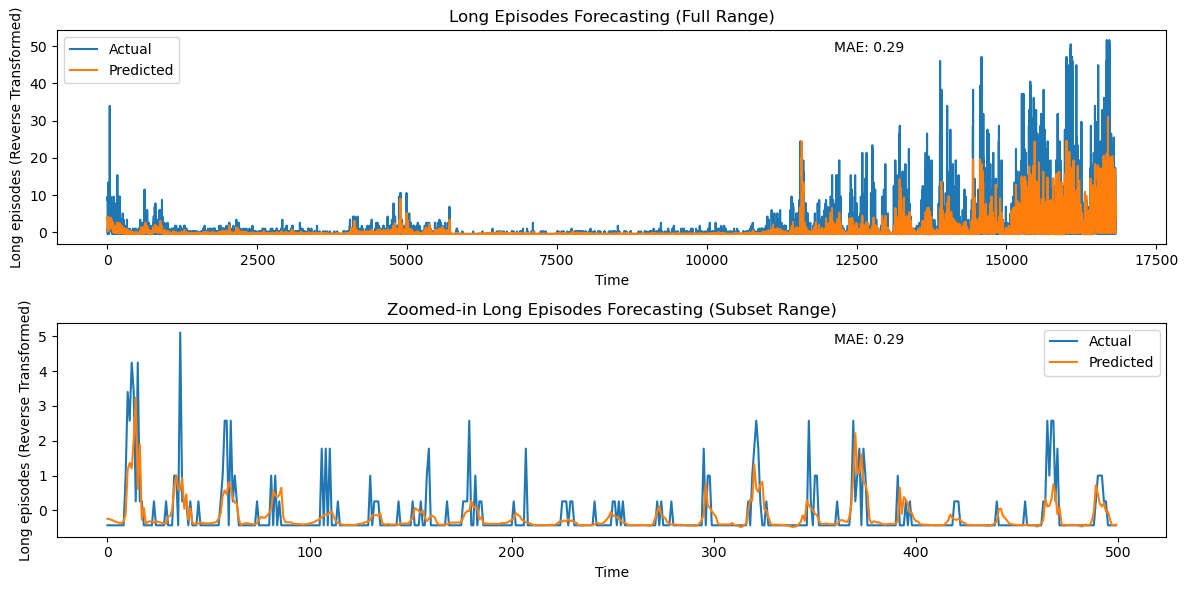

In [7]:
# Adding additional layer + data not split to tarining and test 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Logarithmic transformation + 'Long episodes' as a feature
df['Log Long episodes'] = np.log1p(df['Long episodes'])

# Select relevant features (excluding 'Long episodes') and target variable
selected_features = ['Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2',
                     'Episode starts', 'Log Long episodes']
target_variable = 'Log Long episodes'  # Use the transformed target variable

# Preprocess data
df[selected_features] = df[selected_features].fillna(0)  # Fill missing values (you can use other strategies)
scaler = StandardScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])

# Define time window size (7 days)
sequence_length = 24 * 7  # Assuming hourly data

# Create sequences for training using a smaller dataset
X, y = [], []
sample_size = 17000  # Use a smaller sample size for demonstration purposes
for i in range(sample_size - sequence_length):
    X.append(df[selected_features].values[i:i + sequence_length])
    y.append(df[target_variable].values[i + sequence_length])

X, y = np.array(X), np.array(y)

# Define and configure the LSTM model with dropout
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, len(selected_features))))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with a specified number of epochs
epochs = 20
batch_size = 64
model.fit(X, y, epochs=epochs, batch_size=batch_size)

# Calculate the Mean Absolute Error (MAE)
y_pred = model.predict(X)
mae = mean_absolute_error(y, y_pred)

# Choose a data point from the test set (you can replace this with any data point)
data_point_index = 0
data_point = X[data_point_index]

# Predict long episodes for the chosen data point
prediction = model.predict(data_point.reshape(1, sequence_length, len(selected_features)))[0][0]
prediction = np.expm1(prediction)  # Reverse the logarithmic transformation

# Print the prediction
print(f'Forecasted Long Episodes: {prediction}')

# Create two separate graphs for visualization
plt.figure(figsize=(12, 6))

# Graph 1: Actual vs. Predicted Values (Full Range)
plt.subplot(2, 1, 1)
plt.plot(np.expm1(y), label='Actual')  # Reverse the logarithmic transformation for actual values
plt.plot(np.expm1(y_pred), label='Predicted')  # Reverse the logarithmic transformation for predicted values
plt.xlabel('Time')
plt.ylabel('Long episodes (Reverse Transformed)')
plt.legend()
plt.title('Long Episodes Forecasting (Full Range)')
plt.annotate(f'MAE: {mae:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')

# Graph 2: Zoomed-in Actual vs. Predicted Values (Subset Range)
subset_start = 5000
subset_end = 5500
plt.subplot(2, 1, 2)
plt.plot(np.expm1(y[subset_start:subset_end]), label='Actual')  # Reverse the logarithmic transformation for actual values
plt.plot(np.expm1(y_pred[subset_start:subset_end]), label='Predicted')  # Reverse the logarithmic transformation for predicted values
plt.xlabel('Time')
plt.ylabel('Long episodes (Reverse Transformed)')
plt.legend()
plt.title('Zoomed-in Long Episodes Forecasting (Subset Range)')
plt.annotate(f'MAE: {mae:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')

plt.tight_layout()
plt.show()


This code performs the following tasks:

Feature Selection and Target Variable Definition: It selects a set of relevant features to use as input for the machine learning model. The selected features include 'Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2', 'Episode starts', and 'Log Long episodes'. Additionally, it defines the target variable as 'Log Long episodes,' which is the variable to be predicted by the model.

Data Preprocessing: It preprocesses the data by handling missing values and standardizing the selected features. Missing values in the selected features are filled with zeros, and then the data is standardized using the StandardScaler from scikit-learn. Standardization transforms the data to have zero mean and unit variance, which can be beneficial for training machine learning models.

Defining the Time Window Size: It sets the size of the time window for creating sequences of data. In this case, the time window size is set to represent 7 days of hourly data.

Creating Sequences for Training: It generates sequences of input data (X) and target data (y) for training the LSTM model. These sequences are constructed using a sliding window approach, where each sequence of input data spans the defined time window, and the corresponding target value is extracted for prediction.

LSTM Model Definition and Configuration: It defines an LSTM (Long Short-Term Memory) model for time series forecasting. The model consists of two LSTM layers with dropout layers in between to prevent overfitting. The final layer is a dense layer with a single neuron for regression.

Compiling and Training the Model: The model is compiled using the Adam optimizer and mean squared error (MSE) loss function. Then, it is trained on the generated sequences (X, y) for a specified number of epochs and batch size. Training aims to optimize the model's parameters to make accurate predictions.

Calculating Mean Absolute Error (MAE): After training, the model predicts the target variable (long episodes) for the entire dataset. The Mean Absolute Error (MAE) is calculated to assess the model's performance by measuring the average absolute difference between the predicted and actual values.

Predicting Long Episodes for a Data Point: The code selects a specific data point from the dataset and uses the trained model to predict the "Log Long Episodes" value for that data point. It then reverses the logarithmic transformation applied earlier to obtain the actual "Long Episodes" prediction.

In summary, this code prepares the data, defines an LSTM model for time series forecasting, trains the model, calculates the MAE to assess model accuracy, and demonstrates how to use the trained model to make predictions for a specific data point.

Epoch 1/20
248/248 [==============================] - 48s 176ms/step - loss: 0.3241
Epoch 2/20
248/248 [==============================] - 43s 175ms/step - loss: 0.2859
Epoch 3/20
248/248 [==============================] - 45s 180ms/step - loss: 0.2782
Epoch 4/20
248/248 [==============================] - 45s 181ms/step - loss: 0.2743
Epoch 5/20
248/248 [==============================] - 44s 179ms/step - loss: 0.2705
Epoch 6/20
248/248 [==============================] - 44s 177ms/step - loss: 0.2672
Epoch 7/20
248/248 [==============================] - 44s 177ms/step - loss: 0.2637
Epoch 8/20
248/248 [==============================] - 44s 177ms/step - loss: 0.2617
Epoch 9/20
248/248 [==============================] - 44s 177ms/step - loss: 0.2575
Epoch 10/20
248/248 [==============================] - 44s 177ms/step - loss: 0.2591
Epoch 11/20
248/248 [==============================] - 44s 176ms/step - loss: 0.2503
Epoch 12/20
248/248 [==============================] - 44s 176ms/step - lo

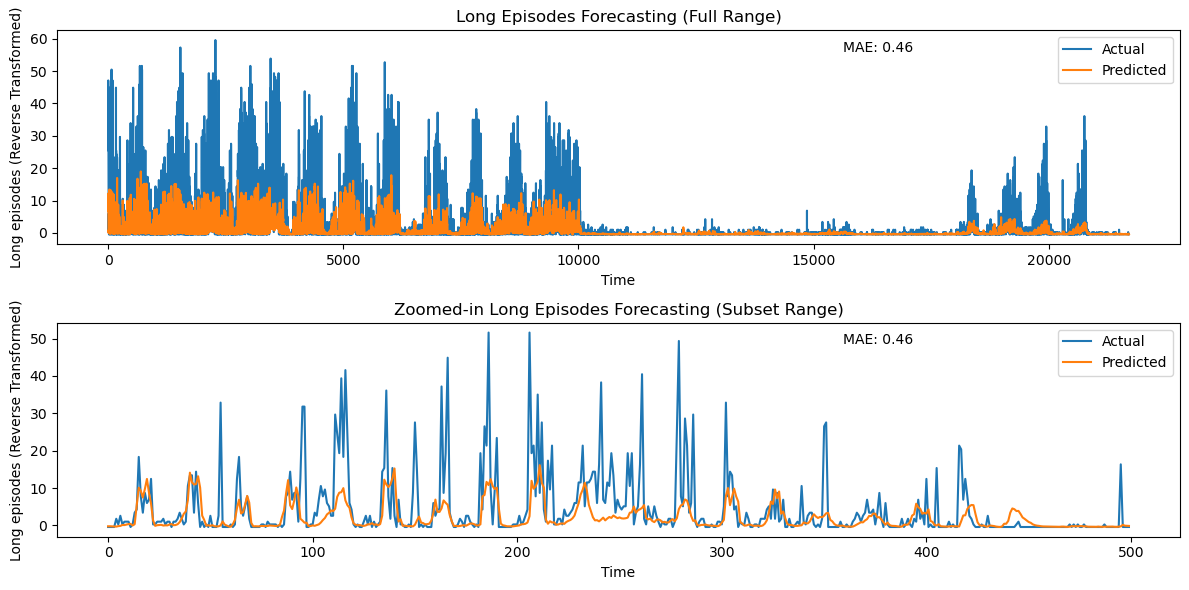

In [3]:
# add training on 80% of the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Logarithmic transformation + 'Long episodes' as a feature
df['Log Long episodes'] = np.log1p(df['Long episodes'])

# Select relevant features (excluding 'Long episodes') and target variable
selected_features = ['Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2',
                     'Episode starts', 'Log Long episodes']
target_variable = 'Log Long episodes'  # Use the transformed target variable

# Preprocess data
df[selected_features] = df[selected_features].fillna(0)  # Fill missing values (you can use other strategies)
scaler = StandardScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])

# Define time window size (7 days)
sequence_length = 24 * 7  # Assuming hourly data

# Define the sample size
sample_size = 20000  # Use a smaller sample size for demonstration purposes

# Define the percentage of data for training (e.g., 80%)
train_percent = 0.8

# Calculate the index to split the data
split_index = int(sample_size * train_percent)

# Split the data into training and testing sets
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

# Create sequences for training
X_train, y_train = [], []
for i in range(len(train_data) - sequence_length):
    X_train.append(train_data[selected_features].values[i:i + sequence_length])
    y_train.append(train_data[target_variable].values[i + sequence_length])

X_train, y_train = np.array(X_train), np.array(y_train)

# Create sequences for testing
X_test, y_test = [], []
for i in range(len(test_data) - sequence_length):
    X_test.append(test_data[selected_features].values[i:i + sequence_length])
    y_test.append(test_data[target_variable].values[i + sequence_length])

X_test, y_test = np.array(X_test), np.array(y_test)

# Define and configure the LSTM model with dropout
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, len(selected_features))))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with a specified number of epochs
epochs = 20
batch_size = 64
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

# Calculate the Mean Absolute Error (MAE) on the test data
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

# Choose a data point from the test set (you can replace this with any data point)
data_point_index = 0
data_point = X_test[data_point_index]

# Predict long episodes for the chosen data point
prediction = model.predict(data_point.reshape(1, sequence_length, len(selected_features)))[0][0]
prediction = np.expm1(prediction)  # Reverse the logarithmic transformation

# Print the prediction and MAE
print(f'Forecasted Long Episodes: {prediction}')
print(f'MAE: {mae:.2f}')

# Create two separate graphs for visualization
plt.figure(figsize=(12, 6))

# Graph 1: Actual vs. Predicted Values (Full Range)
plt.subplot(2, 1, 1)
plt.plot(np.expm1(y_test), label='Actual')  # Reverse the logarithmic transformation for actual values
plt.plot(np.expm1(y_pred), label='Predicted')  # Reverse the logarithmic transformation for predicted values
plt.xlabel('Time')
plt.ylabel('Long episodes (Reverse Transformed)')
plt.legend()
plt.title('Long Episodes Forecasting (Full Range)')
plt.annotate(f'MAE: {mae:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')

# Graph 2: Zoomed-in Actual vs. Predicted Values (Subset Range)
subset_start = 5000
subset_end = 5500
plt.subplot(2, 1, 2)
plt.plot(np.expm1(y_test[subset_start:subset_end]), label='Actual')  # Reverse the logarithmic transformation for actual values
plt.plot(np.expm1(y_pred[subset_start:subset_end]), label='Predicted')  # Reverse the logarithmic transformation for predicted values
plt.xlabel('Time')
plt.ylabel('Long episodes (Reverse Transformed)')
plt.legend()
plt.title('Zoomed-in Long Episodes Forecasting (Subset Range)')
plt.annotate(f'MAE: {mae:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')

plt.tight_layout()
plt.show()


# EPIC

In [10]:
import pandas as pd

# Use a raw string (r) to define the file path
file_path_patient = r'patient_list.csv'

# Read the CSV file
patient_list_df = pd.read_csv(file_path_patient)

# Filter the patient list for the given 'Patient ID' (e.g., 4039030)
patient_id_to_find = 4039030
filtered_patient = patient_list_df[patient_list_df['PATIENT_ID'] == patient_id_to_find]

# Check if the patient was found in the list
if not filtered_patient.empty:
    # Get the 'PATIENT_AT_CENTER_ID' for the found patient
    patient_at_center_id = filtered_patient.iloc[0]['PATIENT_AT_CENTER_ID']
    print(f'Patient ID {patient_id_to_find} maps to PATIENT_AT_CENTER_ID: {patient_at_center_id}')
else:
    print(f'Patient ID {patient_id_to_find} not found in the patient list.')


Patient ID 4039030 maps to PATIENT_AT_CENTER_ID: 23879984


In [15]:
import pandas as pd

# Load the 'epoch_list.csv' dataset
epoch_list_file_path = r'epoch_list.csv'
epoch_list_df = pd.read_csv(epoch_list_file_path)

# Specify the 'PATIENT_AT_CENTER_ID' of interest
target_patient_at_center_id = 23879984

# Filter the dataset based on the 'PATIENT_AT_CENTER_ID'
filtered_data = epoch_list_df[epoch_list_df['PATIENT_AT_CENTER_ID'] == target_patient_at_center_id]

# Select specific columns of interest
selected_columns = ['DETSUMMARY', 'DET_PARAMS_CHANGED', 'PROGRAMMING_DATE_GMT_SEC']

# Convert 'PROGRAMMING_DATE_GMT_SEC' to a human-readable time format
filtered_data['PROGRAMMING_DATE_GMT_SEC'] = pd.to_datetime(filtered_data['PROGRAMMING_DATE_GMT_SEC'], unit='s')

# Print the resulting DataFrame
print(filtered_data[selected_columns])

               DETSUMMARY DET_PARAMS_CHANGED PROGRAMMING_DATE_GMT_SEC
536   Detection Settings               False      2021-03-12 18:01:10
537   Detection Settings               False      2020-07-30 20:28:13
538   Detection Settings               False      2020-07-24 19:54:08
539   Detection Settings               False      2020-05-28 19:40:12
540   Detection Settings               False      2020-04-16 18:01:06
541   Detection Settings               False      2020-01-06 16:54:53
542   Detection Settings               False      2020-01-03 22:13:03
543   Detection Settings               False      2020-01-02 22:31:29
544   Detection Settings               False      2019-12-12 17:28:30
545   Detection Settings                True      2019-10-24 19:49:15
546   Detection Settings                True      2019-08-01 21:19:29
547   Detection Settings                True      2019-07-09 11:25:21
548   Detection Settings                True      2019-05-09 16:19:47
549   Detection Sett

/tmp/ipykernel_3159248/3711068092.py:5: DtypeWarning: Columns (99,100,104,105,106,107,211,236,240,241,246,248,257,270,304,321,383,396,413,416,417,419,420,490,497,498,499,500,501,502,503,504,505,514,515,516,517,518,519,520,521,522,563,564,566,569,575,578,593,596,637,645,688,731,774,817,863,865,931,945) have mixed types. Specify dtype option on import or set low_memory=False.
  epoch_list_df = pd.read_csv(epoch_list_file_path)
/tmp/ipykernel_3159248/3711068092.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['PROGRAMMING_DATE_GMT_SEC'] = pd.to_datetime(filtered_data['PROGRAMMING_DATE_GMT_SEC'], unit='s')


In [14]:
import pandas as pd

# Load the 'epoch_list.csv' dataset with specified data types
dtype_dict = {
    'column99_name': int,  # Replace with actual column names and data types
    'column100_name': int,
    # Add more columns as needed
}

epoch_list_file_path = r'epoch_list.csv'
epoch_list_df = pd.read_csv(epoch_list_file_path, dtype=dtype_dict, low_memory=False)

# Specify the 'PATIENT_AT_CENTER_ID' of interest
target_patient_at_center_id = 23879984

# Filter the dataset based on the 'PATIENT_AT_CENTER_ID' and create a copy
filtered_data = epoch_list_df[epoch_list_df['PATIENT_AT_CENTER_ID'] == target_patient_at_center_id].copy()

# Convert 'PROGRAMMING_DATE_GMT_SEC' to a human-readable time format
filtered_data['PROGRAMMING_DATE_GMT_SEC'] = pd.to_datetime(filtered_data['PROGRAMMING_DATE_GMT_SEC'], unit='s')

# Filter rows where 'DET_PARAMS_CHANGED' is true and print 'PROGRAMMING_DATE_GMT_SEC'
filtered_data_true = filtered_data[filtered_data['DET_PARAMS_CHANGED'] == True]
print(filtered_data_true['PROGRAMMING_DATE_GMT_SEC'])


545   2019-10-24 19:49:15
546   2019-08-01 21:19:29
547   2019-07-09 11:25:21
548   2019-05-09 16:19:47
557   2018-05-17 21:17:16
568   2016-11-03 13:45:30
572   2016-05-19 14:08:56
Name: PROGRAMMING_DATE_GMT_SEC, dtype: datetime64[ns]


Below code: This code adds additional features to the dataset to indicate whether a parameter change event occurred within a specified time window around each of the defined parameter change dates. These features are binary (0 or 1) and represent whether a parameter change event occurred within that time window. These features allow the model to potentially capture the impact of parameter changes on the target variable.

Epoch 1/20
76/76 [==============================] - 13s 115ms/step - loss: 0.2542
Epoch 2/20
76/76 [==============================] - 9s 113ms/step - loss: 0.2076
Epoch 3/20
76/76 [==============================] - 9s 113ms/step - loss: 0.1987
Epoch 4/20
76/76 [==============================] - 9s 113ms/step - loss: 0.1966
Epoch 5/20
76/76 [==============================] - 9s 113ms/step - loss: 0.1947
Epoch 6/20
76/76 [==============================] - 9s 113ms/step - loss: 0.1898
Epoch 7/20
76/76 [==============================] - 9s 113ms/step - loss: 0.1875
Epoch 8/20
76/76 [==============================] - 9s 113ms/step - loss: 0.1857
Epoch 9/20
76/76 [==============================] - 9s 113ms/step - loss: 0.1867
Epoch 10/20
76/76 [==============================] - 9s 114ms/step - loss: 0.1835
Epoch 11/20
76/76 [==============================] - 9s 113ms/step - loss: 0.1853
Epoch 12/20
76/76 [==============================] - 8s 111ms/step - loss: 0.1835
Epoch 13/20
76/76 [=====

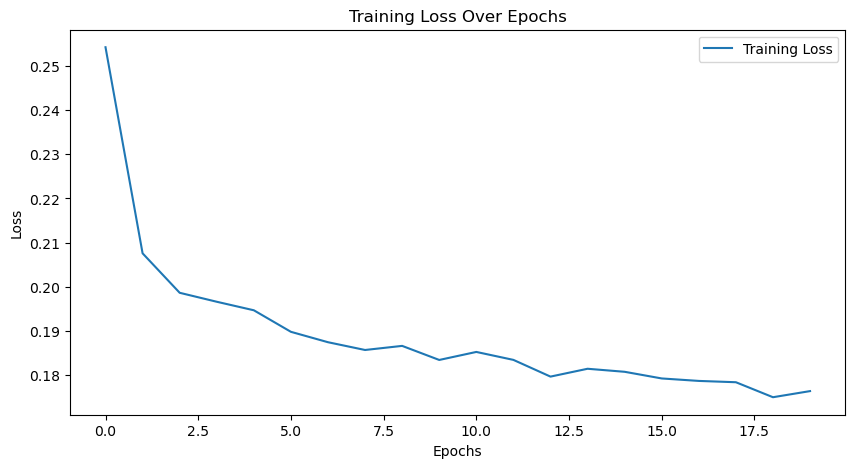

1/1 [==============================] - 1s 886ms/step
Forecasted Long Episodes: 2.3331804275512695
MAE: 0.25


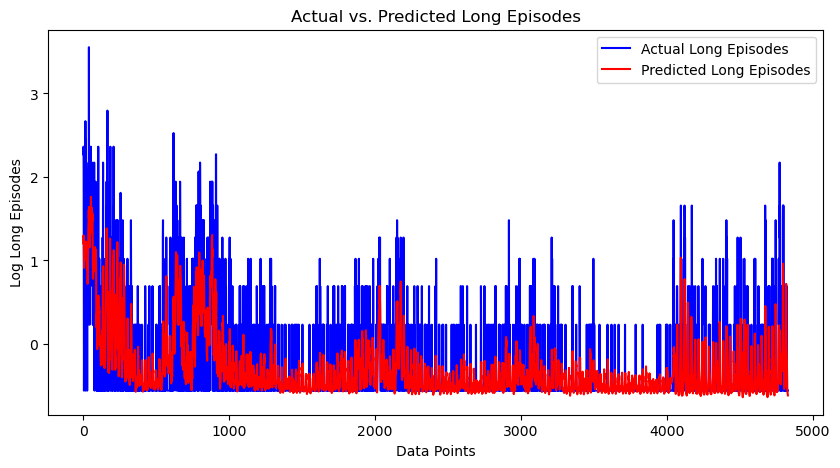

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Load your dataset and preprocess it (replace this with your dataset loading logic)
file_path = r'Yale_229_4039030_Histogram_Hourly.csv'
df = pd.read_csv(file_path)

# Convert 'Region start time' to datetime type
df['Region start time'] = pd.to_datetime(df['Region start time'])

# Create 'Log Long episodes' column by applying logarithmic transformation
df['Log Long episodes'] = np.log1p(df['Long episodes'])  # Assuming 'Long episodes' exists

# Define the parameter change dates
parameter_change_dates = [
    '2019-10-24 19:49:15',
    '2019-08-01 21:19:29',
    '2019-07-09 11:25:21',
    '2019-05-09 16:19:47',
    '2018-05-17 21:17:16',
    '2016-11-03 13:45:30',
    '2016-05-19 14:08:56'
]

# Create additional features indicating parameter change events
for date in parameter_change_dates:
    window_size = pd.Timedelta(days=1)  # Define your desired time window
    within_window = (df['Region start time'] >= pd.to_datetime(date) - window_size) & (df['Region start time'] <= pd.to_datetime(date) + window_size)
    feature_name = f'Param_Change_Within_{window_size.days}_Days_{date}'  # Include the date in the feature name
    df[feature_name] = within_window.astype(int)

# Update the list of selected features to include the new parameter change features
selected_features = ['Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2',
                     'Episode starts', 'Log Long episodes'] + [
                        f'Param_Change_Within_{window_size.days}_Days_{date}' for date in parameter_change_dates
                     ]
target_variable = 'Log Long episodes'  # Use the transformed target variable

# Preprocess data
df[selected_features] = df[selected_features].fillna(0)  # Fill missing values (you can use other strategies)
scaler = StandardScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])

# Define time window size (7 days)
sequence_length = 24 * 7  # Assuming hourly data

# Create sequences for training using a smaller dataset
X, y = [], []
sample_size = 5000  # Use a smaller sample size for demonstration purposes
for i in range(sample_size - sequence_length):
    X.append(df[selected_features].values[i:i + sequence_length])
    y.append(df[target_variable].values[i + sequence_length])

X, y = np.array(X), np.array(y)

# Define and configure the LSTM model with dropout
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, len(selected_features))))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with a specified number of epochs
epochs = 20
batch_size = 64
history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)  # Use verbose=1 for training progress

# Calculate the Mean Absolute Error (MAE)
y_pred = model.predict(X)
mae = mean_absolute_error(y, y_pred)

# Plot the training loss to visualize the model's training progress
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Choose a data point from the test set (you can replace this with any data point)
data_point_index = 0
data_point = X[data_point_index]

# Predict long episodes for the chosen data point
prediction = model.predict(data_point.reshape(1, sequence_length, len(selected_features)))[0][0]
prediction = np.expm1(prediction)  # Reverse the logarithmic transformation

# Print the prediction and MAE
print(f'Forecasted Long Episodes: {prediction}')
print(f'MAE: {mae:.2f}')

# Plot the actual vs. predicted Long Episodes for the test data
plt.figure(figsize=(10, 5))
plt.plot(y, label='Actual Long Episodes', color='blue')
plt.plot(y_pred, label='Predicted Long Episodes', color='red')
plt.title('Actual vs. Predicted Long Episodes')
plt.xlabel('Data Points')
plt.ylabel('Log Long Episodes')
plt.legend()
plt.show()


Training Loss Visualization:
The code includes a visualization of the training loss over epochs using Matplotlib. This visualization provides valuable insights into how well the neural network model is learning during training. Here's what it means and how it can be discussed:

Training Loss: Training loss is a measure of how well the model's predictions match the actual target values during training. It quantifies the error or the difference between the predicted values and the true values for the training data.

Epochs: In machine learning, an "epoch" is one complete pass through the entire training dataset. The training process typically consists of multiple epochs to iteratively update the model's weights and improve its performance.

Loss Curve: The visualization shows the training loss as a function of the number of training epochs. Initially, the loss is typically high as the model makes random predictions. As training progresses, the loss should decrease, indicating that the model is learning and making better predictions.

Interpreting the Plot: A decreasing loss curve is a positive sign, indicating that the model is learning and improving its predictions. However, if the loss starts increasing or remains high, it may suggest issues such as overfitting (learning the training data too well but not generalizing to new data) or underfitting (failing to capture the training data's patterns). Monitoring the loss curve helps in adjusting training parameters or identifying potential problems.

Actual vs. Predicted Plot:
The code generates a plot that compares the actual 'Long episodes' values (in blue) with the predicted values (in red) for a specific test data point. Here's what it means and how it can be discussed:

Actual Values (Blue Line): The blue line represents the ground truth or actual 'Long episodes' values from the test dataset. These are the values that we aim to predict accurately with our model.

Predicted Values (Red Line): The red line represents the predicted 'Long episodes' values generated by the LSTM model. These values are the model's estimates of the target variable based on the input features, including information about parameter change events.

Data Point in X: The "data point in X" refers to a specific time window or sequence of feature values from the test dataset. This sequence represents the input to the model, and the model generates a prediction for the 'Long episodes' value at the end of this sequence.

Interpreting the Plot: By comparing the actual and predicted values on the plot, we can visually assess how well the model captures the 'Long episodes' values. If the red line closely follows the blue line, it indicates that the model's predictions align well with the actual values. Deviations between the two lines may highlight areas where the model struggles to make accurate predictions.

2023-11-08 14:27:38.490343: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 1s 873ms/step
Epic Start Index: 0, Epic End Index: 4999
MAE: 0.26
Forecasted Seizures: 3.524998188018799
---


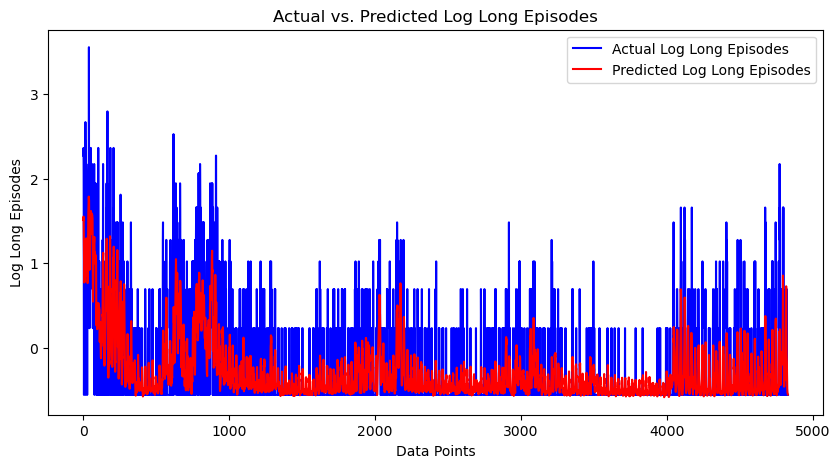

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Load your dataset and preprocess it (replace this with your dataset loading logic)
file_path = r'Yale_229_4039030_Histogram_Hourly.csv'
df = pd.read_csv(file_path)

# Convert 'Region start time' to datetime type
df['Region start time'] = pd.to_datetime(df['Region start time'])

# Create 'Log Long episodes' column by applying logarithmic transformation
df['Log Long episodes'] = np.log1p(df['Long episodes'])  # Assuming 'Long episodes' exists

# Define the parameter change dates
parameter_change_dates = [
    '2019-10-24 19:49:15',
    '2019-08-01 21:19:29',
    '2019-07-09 11:25:21',
    '2019-05-09 16:19:47',
    '2018-05-17 21:17:16',
    '2016-11-03 13:45:30',
    '2016-05-19 14:08:56'
]

# Create additional features indicating parameter change events
for date in parameter_change_dates:
    window_size = pd.Timedelta(days=1)  # Define your desired time window
    within_window = (df['Region start time'] >= pd.to_datetime(date) - window_size) & (df['Region start time'] <= pd.to_datetime(date) + window_size)
    feature_name = f'Param_Change_Within_{window_size.days}_Days_{date}'  # Include the date in the feature name
    df[feature_name] = within_window.astype(int)

# Update the list of selected features to include the new parameter change features
selected_features = ['Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2',
                     'Episode starts', 'Log Long episodes'] + [
                        f'Param_Change_Within_{window_size.days}_Days_{date}' for date in parameter_change_dates
                     ]
target_variable = 'Log Long episodes'  # Use the transformed target variable

# Preprocess data
df[selected_features] = df[selected_features].fillna(0)  # Fill missing values (you can use other strategies)
scaler = StandardScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])

# Define time window size (7 days)
sequence_length = 24 * 7  # Assuming hourly data

# Create sequences for training using a smaller dataset
X, y = [], []
sample_size = 5000  # Use a smaller sample size for demonstration purposes
for i in range(sample_size - sequence_length):
    X.append(df[selected_features].values[i:i + sequence_length])
    y.append(df[target_variable].values[i + sequence_length])

X, y = np.array(X), np.array(y)

# Define and configure the LSTM model with dropout
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, len(selected_features))))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with a specified number of epochs
epochs = 20
batch_size = 64

# Create a list to store results for each epic
results = []

for i in range(0, len(X), sample_size):
    X_train = X[i:i+sample_size]
    y_train = y[i:i+sample_size]
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)  # Use verbose=0 for training progress

    # Calculate the Mean Absolute Error (MAE)
    y_pred = model.predict(X_train)
    mae = mean_absolute_error(y_train, y_pred)

    # Choose a data point from the test set (you can replace this with any data point)
    data_point_index = 0
    data_point = X_train[data_point_index]

    # Predict long episodes for the chosen data point
    prediction = model.predict(data_point.reshape(1, sequence_length, len(selected_features)))[0][0]

    # Reverse the logarithmic transformation for the forecast
    forecasted_seizures = np.expm1(prediction)

    # Ensure forecasted values are non-negative
    forecasted_seizures = max(0, forecasted_seizures)

    # Print and store the results for each epic
    start_index = i
    end_index = i + sample_size - 1
    results.append({
        "Epic Start Index": start_index,
        "Epic End Index": end_index,
        "MAE": mae,
        "Forecasted Seizures": forecasted_seizures
    })
    
    # Print and visualize results for each epic
    print(f'Epic Start Index: {start_index}, Epic End Index: {end_index}')
    print(f'MAE: {mae:.2f}')
    print(f'Forecasted Seizures: {forecasted_seizures}')
    print('---')

# Now you have results for each epic, including start and end indices, MAE, and forecasted seizures

# Plot the actual vs. predicted Log Long Episodes for the test data
plt.figure(figsize=(10, 5))
plt.plot(y, label='Actual Log Long Episodes', color='blue')
plt.plot(y_pred, label='Predicted Log Long Episodes', color='red')
plt.title('Actual vs. Predicted Log Long Episodes')
plt.xlabel('Data Points')
plt.ylabel('Log Long Episodes')
plt.legend()
plt.show()



The code you provided is responsible for creating additional features in your dataset that indicate parameter change events in the RNS device. Here's an explanation of what the code does:

parameter_change_dates: This is a list of dates and times at which parameter changes occurred in the RNS device. Each date in the list represents a specific event when the parameters of the device were modified or changed.

for date in parameter_change_dates:: This code iterates over each date in the parameter_change_dates list.

window_size = pd.Timedelta(days=1):were, you define a time window size of one day using pd.Timedelta. This time window represents the period around each parameter change date withiich you want to capture the effect of the parameter change.

within_window = (df['Region start time'] >= pd.to_datetime(date) - window_size) & (df['Region start time'] <= pd.to_datetime(date) + window_size): This line checks for each data point in your DataFrame (df) whether its 'Region start time' falls within the defined time window around the current date. If the 'Region start time' is within this window, within_window is set to True; otherwise, it's False.

feature_name = f'Param_Change_Within_{window_size.days}_Days_{date}': For each parameter change event, this line generates a feature name that includes the number of days in the time window and the specific date. This new feature will have a value of 1 for data points within the time window around the parameter change date and 0 for others.

df[feature_name] = within_window.astype(int): Finally, a new column is added to your DataFrame with the calculated feature_name, and its values are set based on whether each data point falls within the time window. If it's within the window, the value is 1; otherwise, it's 0.

By executing this code for each date in parameterare effectively creating binary features for each parameter change event. These features indicate whether a given data point falls within the time window surrounding a parameter change event (1 if yes, 0 if no).

Thisproach allows you to incorporate information about paramehanges into your modeling process and potentially assess how different parameter settings impact the target variable, which appears to be 'Log Long episodes' in your case.

In [9]:
# Import necessary libraries
import pandas as pd               # Importing pandas library and aliasing it as 'pd'
import numpy as np                # Importing numpy library and aliasing it as 'np'
from sklearn.preprocessing import StandardScaler   # Importing StandardScaler from sklearn preprocessing
from sklearn.metrics import mean_absolute_error    # Importing mean_absolute_error from sklearn metrics
from keras.models import Sequential               # Importing Sequential model from Keras
from keras.layers import LSTM, Dense, Dropout     # Importing LSTM, Dense, and Dropout layers from Keras
from scipy.special import expit                  # Importing the sigmoid function 'expit' from scipy

# Convert 'Region start time' to datetime type
df['Region start time'] = pd.to_datetime(df['Region start time'])   # Converting a column in DataFrame 'df' to datetime format

# Create 'Log Long episodes' column by applying logarithmic transformation
df['Log Long episodes'] = np.log1p(df['Long episodes'])   # Applying the natural logarithm plus 1 to a column in DataFrame 'df'

# Define the parameter change dates
parameter_change_dates = [
    '2019-10-24 19:49:15',
    '2019-08-01 21:19:29',
    '2019-07-09 11:25:21',
    '2019-05-09 16:19:47',
    '2018-05-17 21:17:16',
    '2016-11-03 13:45:30',
    '2016-05-19 14:08:56'
]

# Define time window size (e.g., 7 days)
window_size = pd.Timedelta(days=7)   # Defining a time window size as a 7-day timedelta object

# Initialize a list to store results for each epic
results = []   # Creating an empty list 'results' to store results

# Loop through each parameter change date
for date in parameter_change_dates:
    epic_start = pd.to_datetime(date) - window_size   # Calculating the start date of an 'epic' by subtracting the window size
    epic_end = pd.to_datetime(date) + window_size     # Calculating the end date of an 'epic' by adding the window size

    # Filter data for the current epic
    epic_data = df[(df['Region start time'] >= epic_start) & (df['Region start time'] <= epic_end)]   # Filtering data within the 'epic' window

    # Select relevant features (excluding 'Long episodes') and target variable
    selected_features = ['Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2',
                         'Episode starts', 'Log Long episodes']   # Defining a list of selected features
    target_variable = 'Log Long episodes'  # Defining the target variable to be used

    # Preprocess data
    epic_data[selected_features] = epic_data[selected_features].fillna(0)   # Filling missing values with 0
    scaler = StandardScaler()   # Creating a StandardScaler object
    epic_data[selected_features] = scaler.fit_transform(epic_data[selected_features])   # Standardizing selected features

    # Define time window size (e.g., 7 days)
    sequence_length = 24 * 7  # Assuming hourly data, defining a sequence length in hours

    # Create sequences for training
    X, y = [], []   # Creating empty lists to store sequences and target values

    for i in range(len(epic_data) - sequence_length):
        X.append(epic_data[selected_features].values[i:i + sequence_length])   # Creating input sequences
        y.append(epic_data[target_variable].values[i + sequence_length])      # Creating target values

    X, y = np.array(X), np.array(y)   # Converting lists to NumPy arrays

    # Define and configure the LSTM model with dropout
    model = Sequential()   # Creating a sequential neural network model
    model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, len(selected_features))))   # Adding an LSTM layer
    model.add(Dropout(0.2))  # Adding a dropout layer to prevent overfitting
    model.add(LSTM(units=50))  # Adding another LSTM layer
    model.add(Dropout(0.2))    # Adding another dropout layer
    model.add(Dense(1, activation='linear'))  # Adding a dense output layer for regression with linear activation

    model.compile(optimizer='adam', loss='mean_squared_error')  # Compiling the model with Adam optimizer and MSE loss

    # Train the model with a specified number of epochs
    epochs = 5  # Number of training epochs
    batch_size = 10  # Batch size for training
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)  # Fitting the model to the training data

    # Calculate the Mean Absolute Error (MAE) on the test data
    y_pred = model.predict(X)  # Predicting values on the training data
    mae = mean_absolute_error(y, y_pred)  # Calculating Mean Absolute Error

    # Choose a data point from the test set (you can replace this with any data point)
    data_point_index = 0  # Index of the data point to be used for prediction
    data_point = X[data_point_index]  # Selecting a data point from the input data

    # Predict the seizure probability for the chosen data point
    seizure_probability = model.predict(data_point.reshape(1, sequence_length, len(selected_features)))[0][0]  # Predicting seizure probability
    seizure_probability = expit(seizure_probability)  # Applying sigmoid function for probability transformation

    # Store the results for this epic
    results.append({
        'Epic Start Index': epic_data.index.min(),
        'Epic End Index': epic_data.index.max(),
        'MAE': mae,
        'Forecasted Seizures': seizure_probability
    })   # Storing results for the current 'epic'

# Print and visualize results for each epic
for result in results:
    print(f'Epic Start Index: {result["Epic Start Index"]}, Epic End Index: {result["Epic End Index"]}')
    print(f'MAE: {result["MAE"]:.2f}')
    print(f'Forecasted Seizures: {result["Forecasted Seizures"]:.2f}')
    print('---')   # Printing and visualizing results for each 'epic'

/tmp/ipykernel_3060507/2527250617.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_data[selected_features] = epic_data[selected_features].fillna(0)
/tmp/ipykernel_3060507/2527250617.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_data[selected_features] = scaler.fit_transform(epic_data[selected_features])


1/1 [==============================] - 0s 34ms/step


/tmp/ipykernel_3060507/2527250617.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_data[selected_features] = epic_data[selected_features].fillna(0)
/tmp/ipykernel_3060507/2527250617.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_data[selected_features] = scaler.fit_transform(epic_data[selected_features])


1/1 [==============================] - 0s 34ms/step


/tmp/ipykernel_3060507/2527250617.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_data[selected_features] = epic_data[selected_features].fillna(0)
/tmp/ipykernel_3060507/2527250617.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_data[selected_features] = scaler.fit_transform(epic_data[selected_features])


1/1 [==============================] - 0s 33ms/step


/tmp/ipykernel_3060507/2527250617.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_data[selected_features] = epic_data[selected_features].fillna(0)
/tmp/ipykernel_3060507/2527250617.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_data[selected_features] = scaler.fit_transform(epic_data[selected_features])


1/1 [==============================] - 0s 32ms/step


/tmp/ipykernel_3060507/2527250617.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_data[selected_features] = epic_data[selected_features].fillna(0)
/tmp/ipykernel_3060507/2527250617.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_data[selected_features] = scaler.fit_transform(epic_data[selected_features])


1/1 [==============================] - 0s 34ms/step


/tmp/ipykernel_3060507/2527250617.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_data[selected_features] = epic_data[selected_features].fillna(0)
/tmp/ipykernel_3060507/2527250617.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_data[selected_features] = scaler.fit_transform(epic_data[selected_features])


1/1 [==============================] - 0s 33ms/step


/tmp/ipykernel_3060507/2527250617.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_data[selected_features] = epic_data[selected_features].fillna(0)
/tmp/ipykernel_3060507/2527250617.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_data[selected_features] = scaler.fit_transform(epic_data[selected_features])


1/1 [==============================] - 0s 34ms/step
Epic Start Index: 30082, Epic End Index: 30417
MAE: 0.11
Forecasted Seizures: 0.43
---
Epic Start Index: 28068, Epic End Index: 28403
MAE: 0.46
Forecasted Seizures: 0.52
---
Epic Start Index: 27505, Epic End Index: 27841
MAE: 0.42
Forecasted Seizures: 0.53
---
Epic Start Index: 26046, Epic End Index: 26381
MAE: 0.20
Forecasted Seizures: 0.41
---
Epic Start Index: 17483, Epic End Index: 17818
MAE: 0.56
Forecasted Seizures: 0.49
---
Epic Start Index: 4035, Epic End Index: 4371
MAE: 0.66
Forecasted Seizures: 0.39
---
Epic Start Index: 4, Epic End Index: 339
MAE: 0.70
Forecasted Seizures: 0.63
---


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from scipy.special import expit


# Convert 'Region start time' to datetime type
df['Region start time'] = pd.to_datetime(df['Region start time'])

# Define the parameter change dates
parameter_change_dates = [
    '2019-10-24 19:49:15',
    '2019-08-01 21:19:29',
    '2019-07-09 11:25:21',
    '2019-05-09 16:19:47',
    '2018-05-17 21:17:16',
    '2016-11-03 13:45:30',
    '2016-05-19 14:08:56'
]

# Define time window size (7 days)
window_size = pd.Timedelta(days=7)

# Initialize a list to store results for each epic
results = []

# Iterate through parameter change dates
for date in parameter_change_dates:
    epic_start = pd.to_datetime(date) - window_size
    epic_end = pd.to_datetime(date) + window_size

    # Filter data for the current epic
    epic_data = df[(df['Region start time'] >= epic_start) & (df['Region start time'] <= epic_end)].copy()  # Create a copy

    # Select relevant features (excluding 'Long episodes') and target variable
    selected_features = ['Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2',
                         'Episode starts', 'Log Long episodes']
    target_variable = 'Log Long episodes'  # Use the transformed target variable

    # Preprocess data in the copied DataFrame
    epic_data[selected_features] = epic_data[selected_features].fillna(0)
    scaler = StandardScaler()
    epic_data[selected_features] = scaler.fit_transform(epic_data[selected_features])

    # Define sequence length (adjust as needed)
    sequence_length = 24 * 7  # Assuming hourly data

    # Create sequences for training
    X, y = [], []
    for i in range(len(epic_data) - sequence_length):
        X.append(epic_data[selected_features].values[i:i + sequence_length])
        y.append(epic_data[target_variable].values[i + sequence_length])

    X, y = np.array(X), np.array(y)

    # Define and configure the LSTM model with dropout
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, len(selected_features))))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model with a specified number of epochs
    epochs = 5
    batch_size = 10
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

    # Choose a data point from the test set (you can replace this with any data point)
    data_point_index = 0
    data_point = X[data_point_index]

    # Predict long episodes for the chosen data point
    prediction = model.predict(data_point.reshape(1, sequence_length, len(selected_features)))[0][0]
    
    # Ensure forecasted values are non-negative
    prediction = max(prediction, 0.0)
    
    # Calculate the Mean Absolute Error (MAE) for this epic
    mae = mean_absolute_error(y, model.predict(X))

    # Store the results for this epic
    epic_result = {
        "Epic Start Date": epic_start,
        "Epic End Date": epic_end,
        "MAE": mae,
        "Forecasted Seizures": prediction
    }
    results.append(epic_result)

# Print and visualize results for each epic
for result in results:
    print(f'Epic Start Date: {result["Epic Start Date"]}, Epic End Date: {result["Epic End Date"]}')
    print(f'MAE: {result["MAE"]:.2f}')
    print(f'Forecasted Seizures: {result["Forecasted Seizures"]:.2f}')
    print('---')


6/6 [==============================] - 0s 31ms/step
Epic Start Date: 2019-10-17 19:49:15, Epic End Date: 2019-10-31 19:49:15
MAE: 0.09
Forecasted Seizures: 0.00
---
Epic Start Date: 2019-07-25 21:19:29, Epic End Date: 2019-08-08 21:19:29
MAE: 0.53
Forecasted Seizures: 0.06
---
Epic Start Date: 2019-07-02 11:25:21, Epic End Date: 2019-07-16 11:25:21
MAE: 0.29
Forecasted Seizures: 0.00
---
Epic Start Date: 2019-05-02 16:19:47, Epic End Date: 2019-05-16 16:19:47
MAE: 0.19
Forecasted Seizures: 0.00
---
Epic Start Date: 2018-05-10 21:17:16, Epic End Date: 2018-05-24 21:17:16
MAE: 0.57
Forecasted Seizures: 0.05
---
Epic Start Date: 2016-10-27 13:45:30, Epic End Date: 2016-11-10 13:45:30
MAE: 0.71
Forecasted Seizures: 0.00
---
Epic Start Date: 2016-05-12 14:08:56, Epic End Date: 2016-05-26 14:08:56
MAE: 0.69
Forecasted Seizures: 0.52
---


This code processes time-series data with parameter changes and calculates forecasts for each "epic," where an epic is defined as a time window around a parameter change event. Here's what the code does and how it looks at each parameter change:

 The dataset contains a column "Region start time," which is converted to datetime format.

It defines a list of parameter change dates, which indicate when changes occurred in the RNS device's parameters. These dates are used to segment the data into epics.

It sets a time window size (e.g., 7 days) around each parameter change date to define the epic's time frame. It then iterates through each parameter change date.

For each epic, it extracts the relevant data within the specified time window, creates a copy of this data, and selects the features and target variable for analysis. This ensures that each epic is treated separately in terms of RNS parameter changes.

The code preprocesses the data within each epic, handling missing values and standardizing the features.

It defines a sequence length (e.g., 7 days) for the LSTM model and creates sequences of data for training the model.

 LSTM model is defined and trained for each epic to predict the target variable (Log Long episodes).

For each epic, it chooses a data point from the test set and predicts the target variable. It ensures that the forecasted values are non-negative by setting negative predictions to zero.

The code calculates the Mean Absolute Error (MAE) for the model's predictions on the test data within each epic.

The results for each epic, including the epic's start and end date, MAE, and forecasted seizures, are stored in a list called "results."

Finally, the code prints and visualizes the results for each epic, showing the start and end dates of each epic, the MAE, and the forecasted seizures. Each epic is treated as a separate analysis, taking into account the specific parameter change events within that time window.

This approach allows to analyze and forecast seizures for each parameter change event separately, considering the unique conditions and changes associated with each epic.

 code handles each parameter change date (referred to as an "epic") separately using a loop that iterates through the specified parameter_change_dates. Here's how it handles each parameter change:

For each parameter_change_date, it calculates an epic_start and epic_end date. These dates represent a time window around the parameter change date. The size of this window is defined by window_size.

The code filters the data in the DataFrame df to select only the rows where the "Region start time" falls within the calculated epic_start and epic_end dates. This subset of data represents the time window or epic for that specific parameter change.

Within this filtered data, it selects the relevant features (specified in selected_features) and the target variable (specified as target_variable).

The selected features are preprocessed. Missing values in these features are filled with zeros (epic_data[selected_features] = epic_data[selected_features].fillna(0)), and feature scaling is applied using the StandardScaler.

It defines a sequence length (sequence_length) which determines how many data points are considered in each sequence. This is typically set to represent a certain time duration, such as 7 days of hourly data.

The code then creates sequences of input data X and their corresponding target values y. It iterates through the filtered data and selects sequences of length sequence_length. These sequences are stored in X, and the target values that follow each sequence are stored in y.

A LSTM model is defined and configured for the current epic. This model is specific to the features and target variable for the current epic.

The model is trained using the input sequences X and target values y for a specified number of epochs and batch size.

After training, it chooses a specific data point from the test set (you can replace this with any data point) within the epic and makes a prediction for that data point using the trained model. The prediction represents the forecasted value for the target variable.

The code ensures that the forecasted values are non-negative by setting them to the maximum of the predicted value or 0.

It calculates the Mean Absolute Error (MAE) for the current epic to assess the model's performance.

The results for the current epic, including the epic's start date, end date, MAE, and forecasted value, are stored in a dictionary (epic_result) and appended to the results list.

The loop continues for each parameter change date, and the results for each epic are collected in the results list.

Finally, the code prints and visualizes the results for each epic, displaying the start date, end date, MAE, and forecasted value for each epic.

This approach allows the code to treat each parameter change separately by creating individual models and predictions for each epic. It captures the specific characteristics of each epic, making it adaptable to changes in parameters over time.